In [1]:
#loading libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [179]:
#loading dataset
train = pd.read_csv("train.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Blanka Jarmoszko*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [7]:
#...Distribution of continuous variables...#

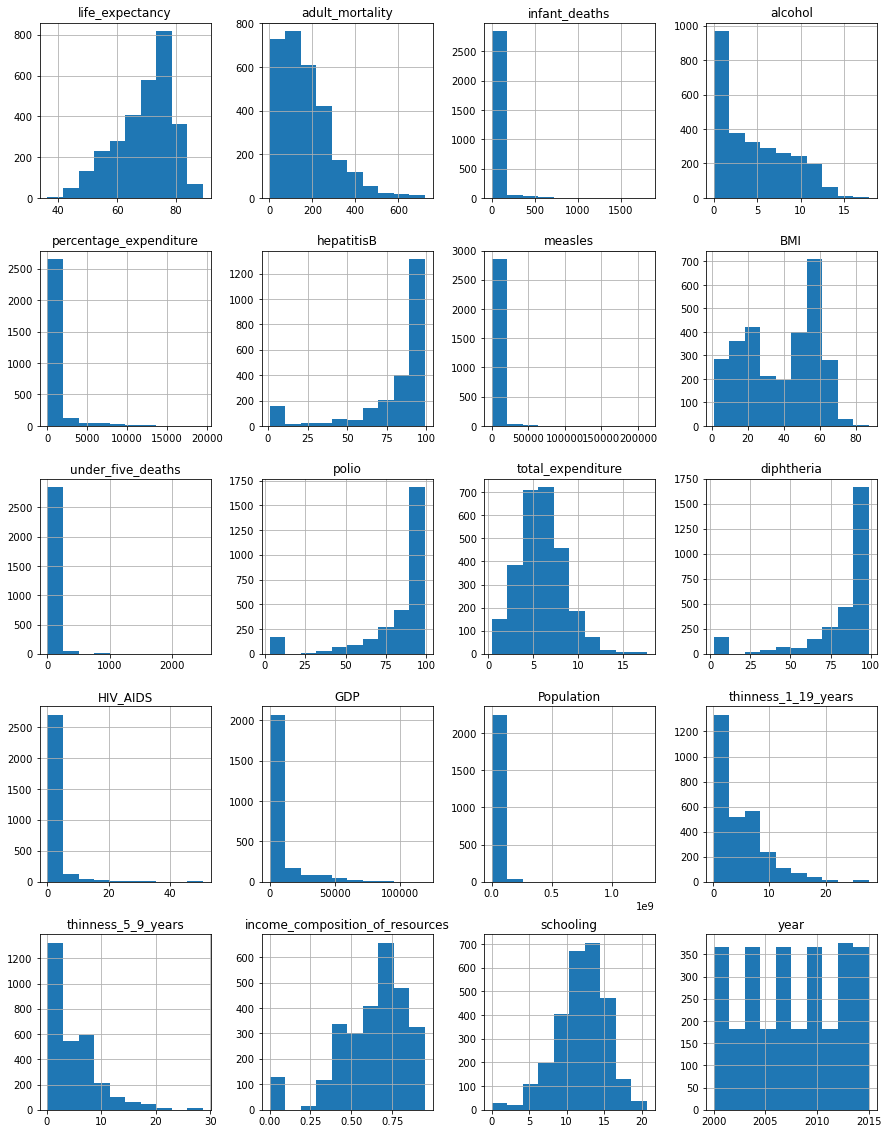

In [24]:
%matplotlib inline
train.hist (column= ['life_expectancy','adult_mortality', 'infant_deaths','alcohol', 'percentage_expenditure', 'hepatitisB',
       'measles', 'BMI', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling','year'],figsize= (15,20))
#hides array names that are otherwise printed
_ = plt.plot()

In [8]:
#...Distribution of categorical variables...#

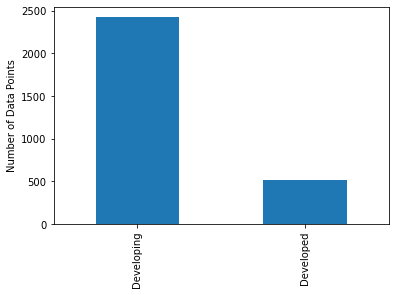

In [22]:
ax = train['status'].value_counts().plot.bar(ylabel = 'Number of Data Points')

In [9]:
#...Association of the response with the predictors...#

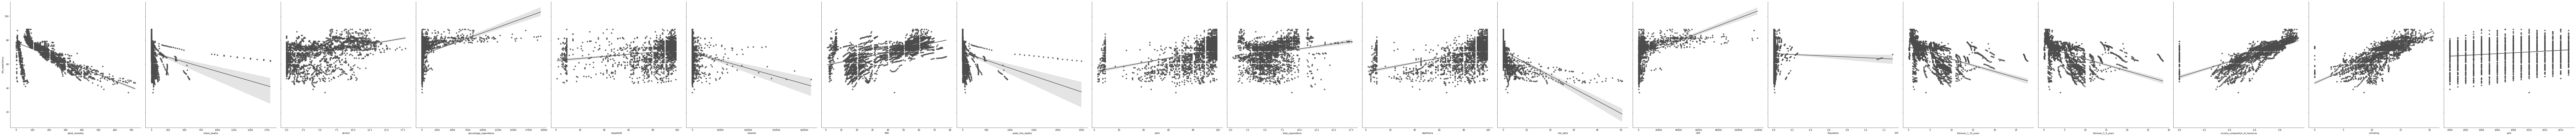

In [33]:
#plotting a scatterplot of life expectancy vs all the other numerical variables to investigate distribution
g = sns.PairGrid(train, y_vars=["life_expectancy"], x_vars=['adult_mortality', 'infant_deaths','alcohol', 'percentage_expenditure', 'hepatitisB',
       'measles', 'BMI', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling','year'], height=9)
g.map(sns.regplot, color=".3")


<AxesSubplot:>

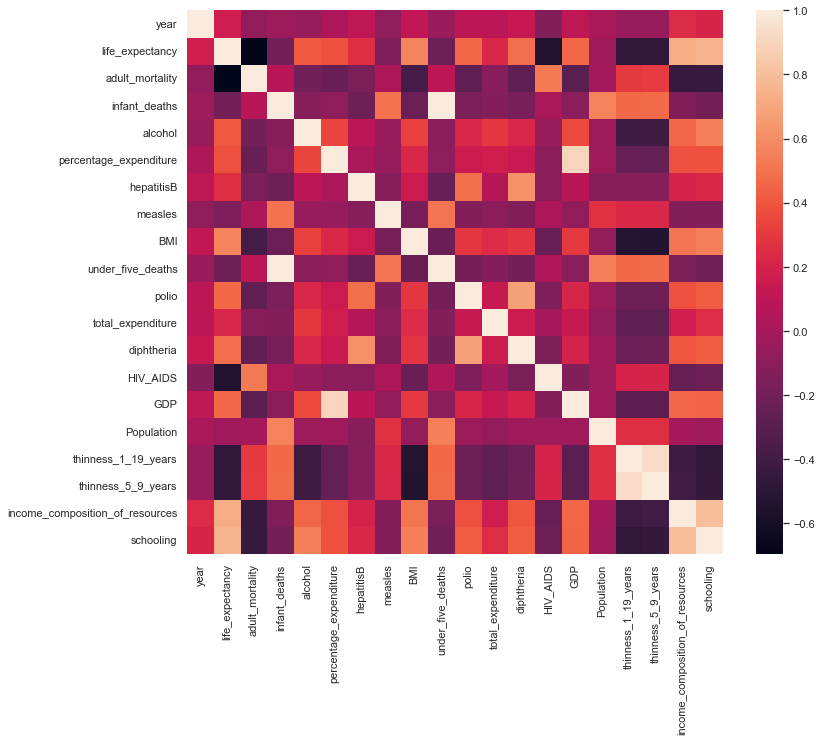

In [34]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(train.corr())

In [42]:
#missing values
train.isnull().sum().sort_values()

country                              0
year                                 0
status                               0
infant_deaths                        0
percentage_expenditure               0
measles                              0
HIV_AIDS                             0
under_five_deaths                    0
life_expectancy                     10
adult_mortality                     10
polio                               19
diphtheria                          19
thinness_5_9_years                  34
thinness_1_19_years                 34
BMI                                 34
schooling                          163
income_composition_of_resources    167
alcohol                            194
total_expenditure                  226
GDP                                448
hepatitisB                         553
Population                         652
dtype: int64

### Data cleaning
*By Blanka Jarmoszko*

From the data quality check we realized that:

1. The column `BMI` has many unreasonably high and low values. The BMI scale ranges between 18-35. However, when looking at the value distributuions over half of the data is outside of those values. To investigate this issue, I found the original WHO data with BMI values for each country over the years of 2000-2015 that our dataset is supposed to utilize. With the initial values BMI looks highly correlated with life-expectancy, in order to fix this issue we will replace the BMI values with the correct values from this data source:
https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)

2. The column `GDP` has many missing values. Due to that it will be hard to impute the values, however based on the present values  `GDP` has a very strong correlation with `percentage_expenditure` thus we can just use keep `percentage_expenditure` and drop GDP. This will also prevent future issues with collinearity that would most likely be present if both `GDP` and `percentage_expenditure` were selected for the model.

3. There are few columns with missing variables, based on the heatplot they are not strongly correlated with life expectancy nor do they appear to have a non-linear correlation. Thus we will not be imputing those variables for now.

The code below implements the above cleaning.

In [ ]:
#...Code with comments...#

In [180]:
train = train.drop(['BMI','GDP'],axis=1)

In [181]:
#imputing bmi values
bmi = pd.read_csv('bmi.csv')

In [182]:
bmi = bmi.drop(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode',
       'Period type', 'IsLatestYear', 'Dim1 type',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type',
       'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource',
       'FactValueNumericPrefix','FactValueUoM',
       'FactValueNumericLowPrefix',
       'FactValueNumericHighPrefix',
       'FactValueTranslationID', 'FactComments', 'Language', 'DateModified','FactValueNumericLow','FactValueNumericHigh','Value'], axis=1)
bmi.drop(bmi[bmi['Period'] > 2015].index, inplace = True)
bmi.drop(bmi[bmi['Period'] < 2000].index, inplace = True)
bmi.drop(bmi[bmi['Dim1'] != 'Both sexes'].index, inplace = True)
bmi['country']=bmi['Location']
bmi['year'] = bmi['Period']
#bmi.drop(bmi[bmi['Location','Period']].index, inplace = True)
bmi = bmi.drop(['Location','Period'], axis=1)

merged = pd.merge(train,bmi,how='left')
merged['BMI']=merged['FactValueNumeric']
merged = merged.drop(['FactValueNumeric','Dim1'],axis=1)
train = merged.copy()

In [169]:
merged = pd.merge(train,bmi,how='left')

array([[<AxesSubplot:title={'center':'BMI'}>]], dtype=object)

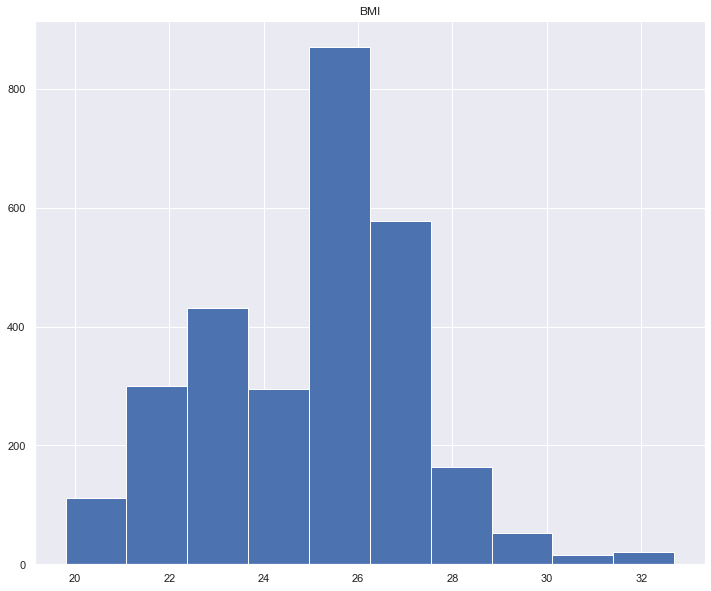

In [183]:
train.hist(column= ['BMI'])

In [184]:
train.isnull().sum().sort_values()

country                              0
HIV_AIDS                             0
measles                              0
percentage_expenditure               0
infant_deaths                        0
under_five_deaths                    0
status                               0
year                                 0
life_expectancy                     10
adult_mortality                     10
polio                               19
diphtheria                          19
thinness_1_19_years                 34
thinness_5_9_years                  34
BMI                                 98
schooling                          163
income_composition_of_resources    167
alcohol                            194
total_expenditure                  226
hepatitisB                         553
Population                         652
dtype: int64

In [185]:
train.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitisB,measles,...,polio,total_expenditure,diphtheria,HIV_AIDS,Population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,BMI
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,33736494.0,17.2,17.3,0.479,10.1,23.3
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,327582.0,17.5,17.5,0.476,10.0,23.2
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,31731688.0,17.7,17.7,0.470,9.9,23.0
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,3696958.0,17.9,18.0,0.463,9.8,22.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,2978599.0,18.2,18.2,0.454,9.5,22.8


### Data preparation
*By Blanka and Jack*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:
CHANGE THIS:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [ ]:
######-----------VIF and Best Subset Selection------------#########

In [220]:
train['developing'] = train.status.apply(lambda x: 1 if x=='Developing'
                       else 0)

In [230]:
abs(train.corrwith(train.life_expectancy)).sort_values()

Population                         0.021538
measles                            0.157586
year                               0.170033
infant_deaths                      0.196557
total_expenditure                  0.218086
under_five_deaths                  0.222529
hepatitisB                         0.256762
percentage_expenditure             0.381864
alcohol                            0.404877
polio                              0.465556
thinness_5_9_years                 0.471584
thinness_1_19_years                0.477183
diphtheria                         0.479495
developing                         0.482136
HIV_AIDS                           0.556556
BMI                                0.603220
adult_mortality                    0.696359
income_composition_of_resources    0.724776
schooling                          0.751975
life_expectancy                    1.000000
dtype: float64

In [241]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[[ 'adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS',  'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [237]:
train_vif = train.dropna()

In [239]:
X = train_vif[[ 'adult_mortality',
       'alcohol', 'percentage_expenditure','polio',
       'diphtheria', 'HIV_AIDS',  'thinness_1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling',
       'BMI', 'developing']]

In [240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                            feature         VIF
0                             const  317.967449
1                   adult_mortality    1.987230
2                           alcohol    2.234194
3            percentage_expenditure    1.390294
4                             polio    1.629757
5                        diphtheria    1.652373
6                          HIV_AIDS    1.642476
7               thinness_1_19_years    7.538975
8                thinness_5_9_years    7.429826
9   income_composition_of_resources    2.903698
10                        schooling    3.774855
11                              BMI    2.276857
12                       developing    1.841789


In [242]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('life_expectancy~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [243]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [244]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 12 models on 1 predictors in 0.09389185905456543 seconds.
Processed 66 models on 2 predictors in 0.3826570510864258 seconds.
Processed 220 models on 3 predictors in 1.7492401599884033 seconds.
Processed 495 models on 4 predictors in 3.7402639389038086 seconds.
Processed 792 models on 5 predictors in 7.213208913803101 seconds.
Processed 924 models on 6 predictors in 10.213942050933838 seconds.
Processed 792 models on 7 predictors in 11.684040069580078 seconds.
Processed 495 models on 8 predictors in 9.781072854995728 seconds.
Processed 220 models on 9 predictors in 4.4659881591796875 seconds.
Processed 66 models on 10 predictors in 1.4168188571929932 seconds.
Processed 12 models on 11 predictors in 0.22694015502929688 seconds.
Processed 1 models on 12 predictors in 0.026209115982055664 seconds.
Total elapsed time: 51.30703091621399 seconds.


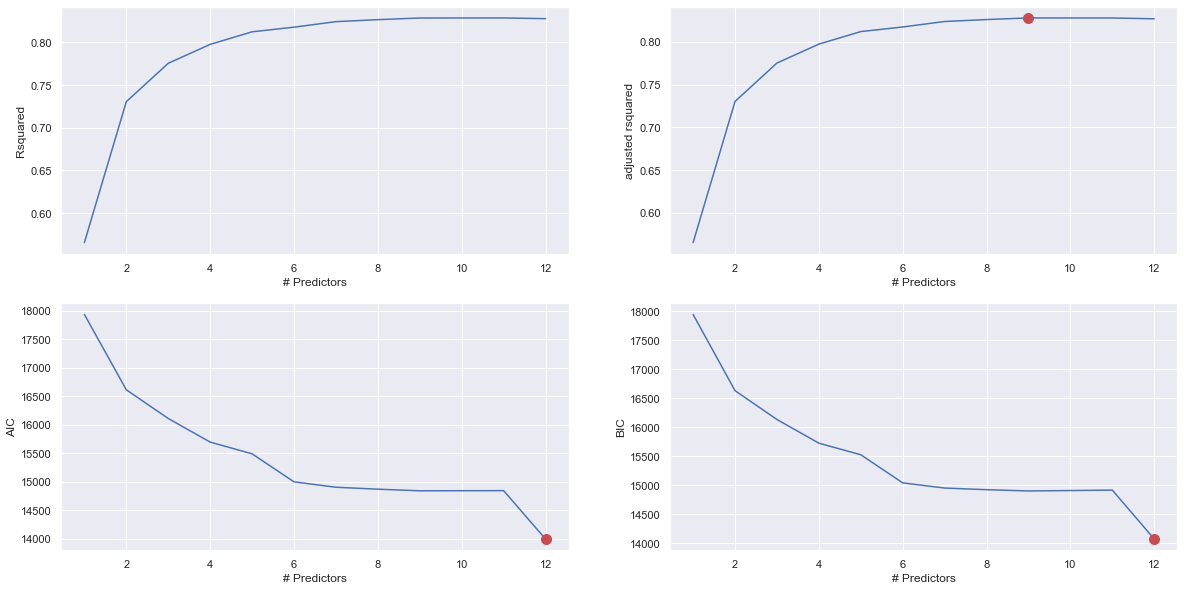

In [245]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [246]:
best_subset_model = models_best.loc[9,'model']
model = models_best.loc[9,'model']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1433.
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:27:02   Log-Likelihood:                -7411.0
No. Observations:                2680   AIC:                         1.484e+04
Df Residuals:                    2670   BIC:                         1.490e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          41.8216      1.010     41.425      0.000      39.842      43.801
adult_mortality                    -0.0156      0.001    -18.675      0.000      -0.017      -0.014
percentage_expenditure              0.0003   4.22e-05      7.711      0.000       0.000       0.000
polio                               0.0245      0.004      5.498      0.000       0.016       0.033
diphtheria                          0.0303      0.004      6.778      0.000       0.022       0.039
HIV_AIDS                           -0.5551      0.021    -27.050      0.000      -0.595      -0.515
income_composition_of_resources     7.5893      0.625     12.138      0.000       6.363       8.815
schooling                           0.8119      0.044     18.575      0.000       0.726       0.898
BMI                                 0.5157      0.045     11.535      0.000       0.428       0.603
developing                         -1.4992      0.254     -5.897      0.000      -1.998      -1.001
==============================================================================
Omnibus:                      143.497   Durbin-Watson:                   0.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              552.165
Skew:                          -0.036   Prob(JB):                    1.26e-120
Kurtosis:                       5.223   Cond. No.                     3.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----------Shuffling the dataset for K-fold------------#########

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.